# Prime Editing (PE) Coverage Analysis – NGG CORRECTED VERSION

- This notebook provides a quantification of the capabilities of prime editing to model mutations present in the MSK IMPACT dataset.
- Assumptions:
    - Using an NGG PAM site for the base editor
    - Haven't thoroughly analyzed potential off-target effects of a given pegRNA
        - Focusing on simply ability to target a mutationw with a pegRNA

For more information regarding MSK IMPACT dataset collection methods, etc., see: 
- https://www.mskcc.org/msk-impact
- https://datacatalog.mskcc.org/dataset/10438

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [5]:
filepath = '/Volumes/Sam_G_SSD/2020-06-16-MSK-IMPACT_EDITED.txt'
impact_data = pd.read_csv(filepath, sep='\t')

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_25055/836307472.py:2: DtypeWarning: Columns (45,48,88) have mixed types. Specify dtype option on import or set low_memory=False.
  impact_data = pd.read_csv(filepath, sep='\t')


In [6]:
impact_data

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,...,VARIANT_CLASS,all_effects,amino_acid_change,cDNA_Change,cDNA_position,cdna_change,comments,n_depth,t_depth,transcript
0,BRCA2,675,MSKCC,GRCh37,13,32937315,32937315,+,splice_acceptor_variant,Splice_Site,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BRCA2,0,MSKCC,37,13,32914437,32914438,+,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MUTYH,4595,MSKCC,GRCh37,1,45798475,45798475,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BRCA2,675,MSKCC,GRCh37,13,32893302,32893302,+,frameshift_variant,Frame_Shift_Ins,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BRCA1,0,MSKCC,37,17,41251824,41251825,+,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422817,SMARCA4,6597,MSKCC,GRCh37,19,11144132,11144132,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422818,BRAF,673,MSKCC,GRCh37,7,140453149,140453149,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422819,NRAS,4893,MSKCC,GRCh37,1,115258747,115258747,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422820,TERT,7015,MSKCC,GRCh37,5,1295521,1295521,+,upstream_gene_variant,5'Flank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#list of unique genes tested
unique_genes = np.unique(np.asarray(impact_data['Hugo_Symbol']))
print('There are ' + str(len(unique_genes)) + ' unique genes observed')

There are 594 unique genes observed


# Loading in reference human genome for epegRNA design

- can check for PAM sequences on either side of the mutation (+/- strand?)
- Downloading reference sequence from: https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.26/ (assembly GRCh38)
- GRCh37: https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.25


In [5]:
from Bio import SeqIO
import gzip

In [6]:
#MSK IMPACT dataset uses GrCh37 build
np.unique(np.asarray(impact_data['NCBI_Build']))

array(['37', 'GRCh37'], dtype=object)

In [7]:
file = '/Volumes/Sam_G_SSD/GRCh37/ncbi-genomes-2022-03-17/GCF_000001405.25_GRCh37.p13_genomic.fna.gz'

with gzip.open(file, "rt") as handle:
    records = list(SeqIO.parse(handle, "fasta")) #about 4 Gb in  memory
    #records = list that contains sequences split up by chromosome (and intrachromosome splits up to some size)

In [8]:
#filtering out alternative sequences to only select consensus matches


wrong = ["alternate", "unplaced", "unlocalized", "patch"]
badlist = []
for key in wrong:
    for i in records:
        ii = i.description
        if key in ii:
            badlist.append(ii)
            
filtered = []
index_list = []
for idx, i in enumerate(records):
    ii = i.description
    if ii not in badlist:
        filtered.append(ii)
        index_list.append(idx)
        
filtered
    

['NC_000001.10 Homo sapiens chromosome 1, GRCh37.p13 Primary Assembly',
 'NC_000002.11 Homo sapiens chromosome 2, GRCh37.p13 Primary Assembly',
 'NC_000003.11 Homo sapiens chromosome 3, GRCh37.p13 Primary Assembly',
 'NC_000004.11 Homo sapiens chromosome 4, GRCh37.p13 Primary Assembly',
 'NC_000005.9 Homo sapiens chromosome 5, GRCh37.p13 Primary Assembly',
 'NC_000006.11 Homo sapiens chromosome 6, GRCh37.p13 Primary Assembly',
 'NC_000007.13 Homo sapiens chromosome 7, GRCh37.p13 Primary Assembly',
 'NC_000008.10 Homo sapiens chromosome 8, GRCh37.p13 Primary Assembly',
 'NC_000009.11 Homo sapiens chromosome 9, GRCh37.p13 Primary Assembly',
 'NC_000010.10 Homo sapiens chromosome 10, GRCh37.p13 Primary Assembly',
 'NC_000011.9 Homo sapiens chromosome 11, GRCh37.p13 Primary Assembly',
 'NC_000012.11 Homo sapiens chromosome 12, GRCh37.p13 Primary Assembly',
 'NC_000013.10 Homo sapiens chromosome 13, GRCh37.p13 Primary Assembly',
 'NC_000014.8 Homo sapiens chromosome 14, GRCh37.p13 Primary A

In [9]:
chromosome = 20
#22 (23-1) = X
#23 (24-1) = Y
#24 (25-1) = mitochondrial DNA
records[index_list[chromosome-1]]

SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN'), id='NC_000020.10', name='NC_000020.10', description='NC_000020.10 Homo sapiens chromosome 20, GRCh37.p13 Primary Assembly', dbxrefs=[])

In [10]:
k=902
print('ref = ' + impact_data.iloc[[k]]['Reference_Allele'].values[0])
#print('al1 = ' + impact_data.iloc[[k]]['Tumor_Seq_Allele1'].values[0])
#print('al2 = ' + impact_data.iloc[[k]]['Tumor_Seq_Allele2'].values[0])
seq_start = impact_data.iloc[[k]]['Start_Position'].values[0]
seq_end = impact_data.iloc[[k]]['End_Position'].values[0]
chromosome = impact_data.iloc[[k]]['Chromosome'].values[0]
seq1 = records[index_list[int(chromosome)-1]].seq
seq1[seq_start-1: seq_end]

ref = TCATCG


Seq('TCATCG')

Sequence start is offset by 1 (i.e. need to subtract 1 from start position to get true sequence information). 

# Loading in gene coordinate information

In [11]:
filename1 = '/Users/samgould/Desktop/FSR Lab/2022-03-17/gene_info.csv'
df1 = pd.read_csv(filename1)
df1

,gene,gene_id,transcript_id,chrom,gene_start,gene_end,transcript_start,transcript_end,strand
0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,133589333,133763062,133710453,133763062,+
1,AC004906.3,ENSG00000237286.1,ENST00000423194.1,chr7,2983669,2986725,2983669,2986725,+
2,AC008738.1,ENSG00000230259.2,ENST00000425420.2,chr19,33790853,33793430,33790853,33793430,-
3,ACTG1,ENSG00000184009.5,ENST00000575842.1,chr17,79476997,79490873,79477015,79479807,-
4,ACVR1,ENSG00000115170.9,ENST00000263640.3,chr2,158592958,158732374,158592958,158731623,-
...,...,...,...,...,...,...,...,...,...
589,XRCC2,ENSG00000196584.2,ENST00000359321.1,chr7,152341864,152373250,152343589,152373250,-
590,YAP1,ENSG00000137693.9,ENST00000282441.5,chr11,101981192,102104154,101981192,102104154,+
591,YES1,ENSG00000176105.9,ENST00000314574.4,chr18,721588,812547,721748,812239,-
592,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,72816784,73093597,72816784,73082274,-


# Prime Editing Coverage Quantification


## Assumptions
- For insertions and deletions, also need to take into account the size of the indel...
- using an NGG PAM sequence
- when looking at the size of the RT template, not taking into account the need for homology at the end of the template...
    - this can be accounted for easily by reducing the size of the RT template.

In [12]:
import re

def prime_domains(gene_name, rt_template_length, df1):
    "Returns vector containing pegRNA coverage for a given gene (+/- 1000 bp of start/end)"
    
    #df1 is the dataframe containing gene sequence information

    gene_chrom = df1[df1['gene']==gene_name]['chrom'].values[0]
    
    if gene_chrom != 'chrX':
        chrom = int(re.search(r'\d+', gene_chrom).group())
    elif gene_chrom=='chrX':
        chrom = 23 #it's number 22, but we subtract 1 below when accessing chromosome file
        #there are no genes in this dataset that fall on Y chromosome -- ignoring

    seq_start = df1[df1['gene']==gene_name]['gene_start'].values[0]
    seq_end = df1[df1['gene']==gene_name]['gene_end'].values[0]

    gene_sequence_1000eitherend = records[index_list[int(chrom)-1]].seq[seq_start-1001: seq_end+1000]
    #gene sequence with 1000 bp buffer on either end to account for prime domains at beginning of gene
    #shitty variable naming; please forgive

    length_seq = len(gene_sequence_1000eitherend)

    zero_array = np.zeros(length_seq)

    #iterate through sequence

    #stop before the end to avoid weird boundary effects...
    for idx, val in enumerate(gene_sequence_1000eitherend[:length_seq-50]): 
        
        by_twos = gene_sequence_1000eitherend[idx:idx+2]
        by_twos_true = by_twos.upper()
        
        if by_twos_true == 'GG': #find NGGs
            zero_array[idx-4:idx+rt_template_length-4] += 1 
            #add array of ones at appropriate index when NGG is encountered
        
        else:
            continue   
            

    #repeat on negative strand
    comp = gene_sequence_1000eitherend.complement() #taking complement (- strand in same orientation)
    for idx, val in enumerate(comp):
        
        by_twos = comp[idx:idx+2]
        by_twos_true = by_twos.upper()
        
        if by_twos_true == 'GG': #find NGGs
            zero_array[idx+5-rt_template_length:idx+5] += 1#add array of ones at appropriate index when NGG is encountered
            #+5 to account for counting from back G instead of front G in NGG
        
        else:
            continue   
    
    
    return zero_array
    
    

In [124]:
filename1 = '/Users/samgould/Desktop/FSR Lab/2022-03-17/gene_info.csv'
df1 = pd.read_csv(filename1)

gene_name = 'TP53'
rt_template_length = 7

kkk = prime_domains(gene_name, rt_template_length, df1)

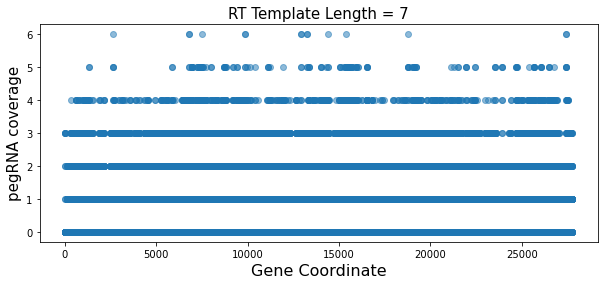

In [125]:
plt.figure(figsize=(10,4))

plt.scatter(range(len(kkk[0:])),kkk[0:], alpha=0.5)
plt.xlabel('Gene Coordinate', fontsize=16)
plt.ylabel('pegRNA coverage', fontsize=15)
plt.title('RT Template Length = ' + str(rt_template_length), fontsize=15);

In [ ]:
#now performing this for each gene and at rt template lengths from 1 to 50
path = '/Volumes/Sam_G_SSD/human genome GrCh37 IMPACT genes/'
unique_genes = np.load(path + 'human_impact_genes_NAMES.npy', allow_pickle=True)
unique_genes = list(unique_genes)

rt_template_length = np.linspace(1,50,50) #iterating through all RT template lengths from 1 to 50

for x in rt_template_length:
    
    rt_template_length = int(x)
    rt_len = [] #coverage array for holding information

    for gene in unique_genes:

        gene_name = gene

        kkk = prime_domains(gene_name, rt_template_length, df1)

        unique, counts = np.unique(kkk, return_counts=True)

        rt_len.append(kkk)
        
    filepath = '/Volumes/Sam_G_SSD/PE coverage NGG npy arrays/'
    np.save(filepath + 'PE_coverage_NGG_rt' + str(rt_template_length) +'.npy', np.asarray(rt_len))
    print('complete rt template length = ' + str(rt_template_length))

    #files provided in dropbox; no need to run this yourself


## Prime editing boundaries
Performing similar analysis, but this time getting coordinates of prime editing domains.

Splitting it up into two arrays, corresponding to (+) strand and (-) strand. This directionality information is required for further analysis. 

The only information needed is the starting location of the editing domain (as well as which strand it's occuring on), which will be marked with a 1 in the array of zeros. From there, with knowledge of the RT template size and the other prime editing domain array, you can check whether a target mutation (applies to insertions and ONPs) falls within the boundary of a single prime editing domain, or crosses multiple domains (in this case the edit isn't possible with the given RT template length). 


In [103]:
import re


#changing it so that I look +/- 1 kb upstream and downstream of each gene to avoid issues with TERT mutations

def prime_domains_boundaries(gene_name, df1):
    #df1 is the dataframe containing gene sequence information

    gene_chrom = df1[df1['gene']==gene_name]['chrom'].values[0]
    
    if gene_chrom != 'chrX':
        chrom = int(re.search(r'\d+', gene_chrom).group())
    elif gene_chrom=='chrX':
        chrom = 23 #it's number 22, but we subtract 1 below when accessing chromosome file
        #there are no genes in this dataset that fall on Y chromosome -- ignoring

    seq_start = df1[df1['gene']==gene_name]['gene_start'].values[0]
    seq_end = df1[df1['gene']==gene_name]['gene_end'].values[0]

    gene_sequence_1000eitherend = records[index_list[int(chrom)-1]].seq[seq_start-1001: seq_end+1000]
    #gene sequence with 1000 bp buffer on either end to account for prime domains at beginning of gene

    length_seq = len(gene_sequence_1000eitherend)

    #two arrays corresponding to plus and minus end
    zero_array_plus = np.zeros(length_seq)
    zero_array_minus = np.zeros(length_seq)

    #iterate through sequence

    #iterate +- 1000 bp from start/end of gene
    for idx, val in enumerate(gene_sequence_1000eitherend): 
        
        by_twos = gene_sequence_1000eitherend[idx:idx+2]
        by_twos_true = by_twos.upper()
        
        if by_twos_true == 'GG': #find NGGs
            zero_array_plus[idx-4] += 1#add array of ones at appropriate index when NGG is encountered
        
        else:
            continue


    #repeat on negative strand
    comp = gene_sequence_1000eitherend.complement() #taking complement (- strand in same orientation)
    for idx, val in enumerate(comp):
        
        if idx+5 < length_seq: #dealing with boundary issue
        
            by_twos = comp[idx:idx+2]
            by_twos_true = by_twos.upper()

            if by_twos_true == 'GG': #find NGGs
                zero_array_minus[idx+5] += 1#add array of ones at appropriate index when NGG is encountered
                #+5 instead of +4 because we're counting from the back of the NGG due to orientation

            else:
                continue
        
        else:
            continue
    
    #might be weird edge effects but I'm not using the very end of either of these arrays regardless...
    
    return [zero_array_plus,zero_array_minus], gene_sequence_1000eitherend
    

In [94]:
#repeating same process as above
filename1 = '/Users/samgould/Desktop/FSR Lab/2022-03-17/gene_info.csv'
df1 = pd.read_csv(filename1)

g = [] #list for holding numpy arrays for each of the genes
for gene in unique_genes:

    gene_name = gene

    kkk = prime_domains_boundaries(gene_name, df1) #marked editing domains for a particular gene

    g.append(kkk) #adding it to master list of all genes (indexed by unique_genes)
    
filepath = '/Users/samgould/Desktop/FSR Lab/2022-06-21/'
np.save(filepath + 'PE_coverage_boundary_NGG_plusminus_1000bp.npy', np.asarray(g))


/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_19707/3088350493.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(filepath + 'PE_coverage_boundary_NGG_plusminus_1000bp.npy', np.asarray(g))


In [100]:
filepath = '/Users/samgould/Desktop/FSR Lab/2022-06-21/'

k = np.load(filepath + 'PE_coverage_boundary_NGG_plusminus_1000bp.npy', allow_pickle=True)


594

# Next step = quantifying whether mutations in IMPACT data set fall within editing windows at varying RT template lengths

variant_type keys: 
- SNP: Single nucleotide polymorphism -- a substitution in one nucleotide
- DNP: Double nucleotide polymorphism -- a substitution in two consecutive nucleotides
- TNP: Triple nucleotide polymorphism -- a substitution in three consecutive nucleotides
- ONP: Oligo-nucleotide polymorphism -- a substitution in more than three consecutive nucleotides
- INS: Insertion -- the addition of nucleotides
- DEL: Deletion -- the removal of nucleotides


In [101]:
mut_types= impact_data['Variant_Type'].value_counts()
mut_types

SNP    348145
DEL     49838
INS     17784
DNP      6042
ONP      1011
UNK         1
TNP         1
Name: Variant_Type, dtype: int64

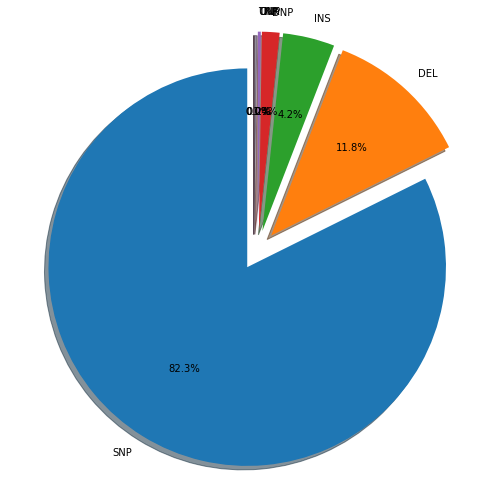

In [102]:
labels = np.asarray(impact_data['Variant_Type'].unique())
sizes = mut_types
explode = (0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()
#plt.savefig('Pie_mutation_rep.png', dpi=200)

## assumptions

- Assuming that RT template length is not limiting for engineering deletions
- However, RT length must be ≥ size of insertion in order for it to work
    - This doesn't account for the need for homology arms. RT template length can be thought of here as the template length with edits included, but excluding the extra basepairs needed for homology...
    - I'm IGNORING the necessity for a region of homology in the RT template. This simplifies the analysis, and any homology requirements can be very simply added to the this analysis without changing the code (e.g. if 10 bp of homology required, and edit can be captured with RT template length of 7 as calculated here, then total RT template length size = 17).

In [19]:
def coverage_classifier(impact_data, df1, rt_template_length):
    #load in (1) impact_data, 
    #(2) df containing gene coordinate info
    #(3) length of rt template
    
    filepath = '/Users/samgould/Desktop/FSR Lab/2022-06-21/'

    PE_domain_boundary = np.load(filepath + 'PE_coverage_boundary_NGG_plusminus_1000bp.npy', allow_pickle=True)  
    
    filepath_coverage = '/Volumes/Sam_G_SSD/PE coverage NGG npy arrays/' + 'PE_coverage_NGG_rt' + str(rt_template_length) +'.npy'
    PE_domain_coverage = np.load(filepath_coverage, allow_pickle=True)
    #for plus and minus strand
    
    path = '/Volumes/Sam_G_SSD/human genome GrCh37 IMPACT genes/'
    unique_genes = np.load(path + 'human_impact_genes_NAMES.npy', allow_pickle=True)
    unique_genes = list(unique_genes)
    
    #iterate through mutations in IMPACT dataset
    num_mutations = len(impact_data)
    
    #initialize array of zeros for holding information about coverage
    zeros = np.zeros(num_mutations)
    
    #initialize array for holding weird cases with bad location
    outside_domain = []
    
    for i in range(num_mutations):

        #get info on current mut
        mut = impact_data.iloc[i]
        
        #getting type of mutations
        mut_type = mut['Variant_Type'] 
        
        #getting gene and start/end position of mutation
        gene = mut['Hugo_Symbol']
        gene_index = unique_genes.index(gene) #retrieving index
        
        seq_start = df1[df1['gene']==gene]['gene_start'].values[0] 
        
        s = mut['Start_Position']
        e = mut['End_Position']
        size_mut = (e-s)+1 #size of mutation
        
        #re-indexing with start of gene as position 0
        start_true = s-(seq_start-1001)
        end_true = e-(seq_start-1001)+1
    
        #retrieving the appropriate gene's prime editing domain
        PE_domain_bound = PE_domain_boundary[gene_index]
        PE_domain = PE_domain_coverage[gene_index]
    
        #first checking for weird boundary misc.
        if (start_true or end_true)>len(PE_domain):
            outside_domain.append(i)
            
        else:

            if mut_type == 'SNP':
                val = PE_domain[start_true]

                if val >0:
                    zeros[i] +=1
                else:
                    continue

            elif mut_type =='DEL':
                #only need to check that the start is in PE domain (not accounting for homology arms)
                val = PE_domain[start_true]

                if val >0:
                    zeros[i] +=1
                else:
                    continue

            elif mut_type == 'INS':
                #first check rt template length is at least size of insertion
                if rt_template_length >= size_mut:
                    pe_cover = PE_domain[start_true:end_true]

                    if all(kk>0 for kk in pe_cover):#then check coverage)

                        plus_end = PE_domain_bound[0] 
                        minus_end = PE_domain_bound[1]
                        #finally check boundary condition
                        diff_sizes = rt_template_length-size_mut

                        bounds_plus = plus_end[start_true-diff_sizes:start_true+1] 
                        bounds_minus = minus_end[end_true:(end_true+diff_sizes+1)]

                        #if start site is anywhere within these bounds, boundary condition satisfied
                        sum_bound = np.sum(bounds_plus)+np.sum(bounds_minus)

                        if sum_bound>=1:

                            zeros[i] +=1
                        else:
                            continue

                    else:
                        continue

                else:
                    continue


            elif mut_type == 'DNP':
                if rt_template_length >= 2:
                    pe_cover = PE_domain[start_true:end_true]

                    if all(kk>0 for kk in pe_cover):#then check coverage)

                        plus_end = PE_domain_bound[0] 
                        minus_end = PE_domain_bound[1]
                        #finally check boundary condition
                        diff_sizes = rt_template_length-size_mut

                        bounds_plus = plus_end[start_true-diff_sizes:start_true+1] 
                        bounds_minus = minus_end[end_true:(end_true+diff_sizes+1)]

                        #if start site is anywhere within these bounds, boundary condition satisfied
                        sum_bound = np.sum(bounds_plus)+np.sum(bounds_minus)

                        if sum_bound>=1:

                            zeros[i] +=1
                        else:
                            continue

                    else:
                        continue

                else:
                    continue


            elif mut_type == 'ONP':
                if rt_template_length >= size_mut:
                    pe_cover = PE_domain[start_true:end_true]

                    if all(kk>0 for kk in pe_cover):#then check coverage)

                        plus_end = PE_domain_bound[0] 
                        minus_end = PE_domain_bound[1]
                        #finally check boundary condition
                        diff_sizes = rt_template_length-size_mut

                        bounds_plus = plus_end[start_true-diff_sizes:start_true+1] 
                        bounds_minus = minus_end[end_true:(end_true+diff_sizes+1)]

                        #if start site is anywhere within these bounds, boundary condition satisfied
                        sum_bound = np.sum(bounds_plus)+np.sum(bounds_minus)

                        if sum_bound>=1:

                            zeros[i] +=1
                        else:
                            continue

                    else:
                        continue

                else:
                    continue


            elif mut_type == 'TNP':
                if rt_template_length >= 3:
                    pe_cover = PE_domain[start_true:end_true]

                    if all(kk>0 for kk in pe_cover):#then check coverage)

                        plus_end = PE_domain_bound[0] 
                        minus_end = PE_domain_bound[1]
                        #finally check boundary condition
                        diff_sizes = rt_template_length-size_mut

                        bounds_plus = plus_end[start_true-diff_sizes:start_true+1] 
                        bounds_minus = minus_end[end_true:(end_true+diff_sizes+1)]

                        #if start site is anywhere within these bounds, boundary condition satisfied
                        sum_bound = np.sum(bounds_plus)+np.sum(bounds_minus)

                        if sum_bound>=1:

                            zeros[i] +=1
                        else:
                            continue

                    else:
                        continue

                else:
                    continue


            elif mut_type == 'UNK':
                #IGNORING UNCLASSIFIED MUTANTS
                continue

    return zeros, outside_domain

In [20]:
rt_template_length = np.linspace(1,50,50) #iterating through all RT template lengths from 1 to 50

one_to_fifty = []
outside = []
for x in rt_template_length:
    
    rt_template_length = int(x)
       
    coverage, outside_domain = coverage_classifier(impact_data, df1, rt_template_length)
    
    one_to_fifty.append(coverage)
    outside.append(outside_domain)
    
    print('complete rt template length = ' + str(rt_template_length))

    
filepath = '/Volumes/Sam_G_SSD/PE coverage quant NGG/'
np.save(filepath + 'MSK_PE_coverage_NGG_rt_1to50' + str(rt_template_length) +'.npy', np.asarray(one_to_fifty))
np.save(filepath + 'outsidedomain_rt1to50' + str(rt_template_length) +'.npy', np.asarray(outside))


complete rt template length = 1
complete rt template length = 2
complete rt template length = 3
complete rt template length = 4
complete rt template length = 5
complete rt template length = 6
complete rt template length = 7
complete rt template length = 8
complete rt template length = 9
complete rt template length = 10
complete rt template length = 11
complete rt template length = 12
complete rt template length = 13
complete rt template length = 14
complete rt template length = 15
complete rt template length = 16
complete rt template length = 17
complete rt template length = 18
complete rt template length = 19
complete rt template length = 20
complete rt template length = 21
complete rt template length = 22
complete rt template length = 23
complete rt template length = 24
complete rt template length = 25
complete rt template length = 26
complete rt template length = 27
complete rt template length = 28
complete rt template length = 29
complete rt template length = 30
complete rt templat

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

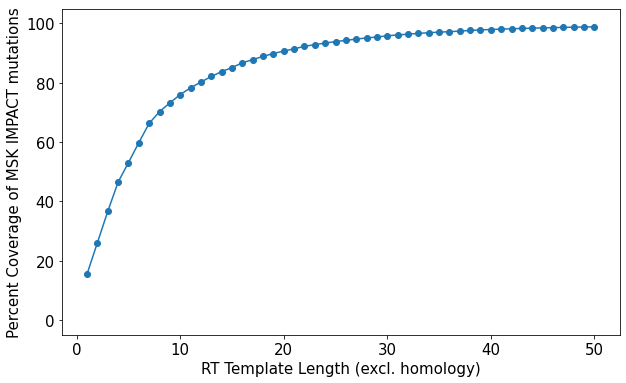

In [33]:
perc_coverage = [(sum(i)-1)/(len(i)-1)*100 for i in one_to_fifty]
rt_template_length = np.linspace(1,50,50) #iterating through all RT template lengths from 1 to 50

plt.figure(figsize=(10,6))
plt.plot(rt_template_length,perc_coverage)
plt.scatter(rt_template_length,perc_coverage)
plt.ylim(-5,105)
plt.ylabel('Percent Coverage of MSK IMPACT mutations', fontsize=15)
plt.xlabel('RT Template Length (excl. homology)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('total_mutations.png', dpi=200)

# Generating PE Coverage Figures

In [1]:
filepath = '/Volumes/Sam_G_SSD/PE coverage quant NGG/MSK_PE_coverage_NGG_rt_1to50.npy'
cover_list = np.load(filepath)

In [2]:
perc_coverage = [(sum(i)-1)/(len(i)-1)*100 for i in cover_list]
#there's a single mutation that doesn't behave

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

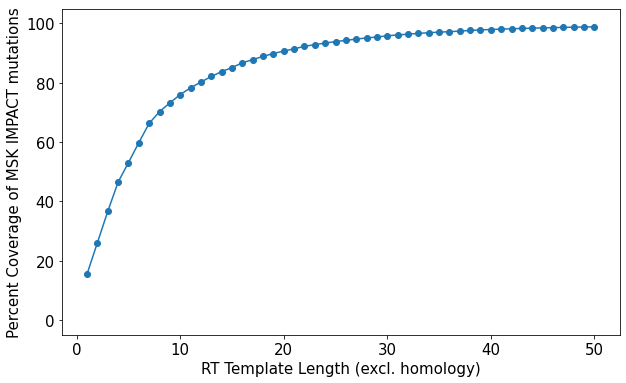

In [8]:

rt_template_length = np.linspace(1,50,50) #iterating through all RT template lengths from 1 to 50

plt.figure(figsize=(10,6))
plt.plot(rt_template_length,perc_coverage)
plt.scatter(rt_template_length,perc_coverage)
plt.ylim(-5,105)
plt.ylabel('Percent Coverage of MSK IMPACT mutations', fontsize=15)
plt.xlabel('RT Template Length (excl. homology)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('total_mutations.png', dpi=200)

## For further analysis, break down into subcategories of mutations (SNPS, INS, DELs, etc.)

## ALSO, need to exclude the indeces that fall outside of the domain. 

In [9]:
ONP = np.asarray(impact_data[impact_data['Variant_Type']=='ONP'].index)
SNP = np.asarray(impact_data[impact_data['Variant_Type']=='SNP'].index)
DNP = np.asarray(impact_data[impact_data['Variant_Type']=='DNP'].index)
TNP = np.asarray(impact_data[impact_data['Variant_Type']=='TNP'].index)
INS = np.asarray(impact_data[impact_data['Variant_Type']=='INS'].index)
DEL = np.asarray(impact_data[impact_data['Variant_Type']=='DEL'].index)

In [10]:
#not the prettiest, or most efficient way to do this, but it works
#could be re-written in about 1000 different ways to be faster
ONP_cover = []
SNP_cover = []
DNP_cover = []
TNP_cover = []
INS_cover = []
DEL_cover = []

ONP1 = []
SNP1 = []
DNP1 = []
TNP1 = []
INS1 = []
DEL1 = []

for i in cover_list: #iterating through different rt template lengths
    sumONP = 0
    sumSNP = 0
    sumDNP = 0
    sumTNP = 0
    sumINS = 0
    sumDEL = 0
    
    for k in ONP:
        sumONP+=i[k]
    
    for k in SNP:
        sumSNP += i[k]
        
    for k in DNP:
        sumDNP += i[k]
    
    for k in TNP:
        sumTNP += i[k]
        
    for k in INS:
        sumINS += i[k]
        
    for k in DEL:
        sumDEL += i[k]
        
        
    #del = counts[0]
    #dnp = counts[1]
    #ins = counts[2]
    #onp = counts[3]
    #snp = counts[4]    
    ONP_cover.append(sumONP/(len(ONP)))
    SNP_cover.append(sumSNP/(len(SNP)))
    DNP_cover.append(sumDNP/(len(DNP)))
    TNP_cover.append(sumTNP/(len(TNP)))
    INS_cover.append(sumINS/(len(INS)))
    DEL_cover.append(sumDEL/(len(DEL)))
    
        #onp = counts[3]
    #snp = counts[4]    
    ONP1.append(sumONP)
    SNP1.append(sumSNP)
    DNP1.append(sumDNP)
    TNP1.append(sumTNP)
    INS1.append(sumINS)
    DEL1.append(sumDEL)



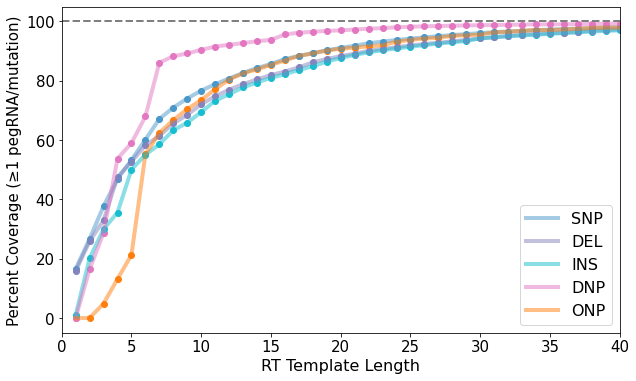

In [53]:
plt.figure(figsize=(10,6))

c_list = [plt.cm.Blues(0.6), 'tab:orange',plt.cm.Purples(0.6),'tab:pink', 'tab:cyan']

plt.plot(rt_template_length,np.asarray(SNP_cover)*100, label='SNP', color=plt.cm.Blues(0.6), linewidth=4, alpha=0.5)
#plt.plot(rt_template_length,TNP_cover, label='TNP' )
plt.plot(rt_template_length,np.asarray(DEL_cover)*100, label='DEL', color=plt.cm.Purples(0.6),linewidth=4, alpha=0.5)


plt.plot(rt_template_length,np.asarray(INS_cover)*100, label='INS' ,color='tab:cyan', linewidth=4, alpha=0.5)
plt.plot(rt_template_length,np.asarray(DNP_cover)*100, label='DNP', color='tab:pink', linewidth=4, alpha=0.5)


plt.plot(rt_template_length,np.asarray(ONP_cover)*100, label='ONP' , color='tab:orange', linewidth=4, alpha=0.5)
plt.plot([0,50], [100,100], linestyle='dashed', c='tab:grey', linewidth=2)


plt.scatter(rt_template_length,np.asarray(ONP_cover)*100, color='tab:orange')
plt.scatter(rt_template_length,np.asarray(SNP_cover)*100, color=plt.cm.Blues(0.6))
plt.scatter(rt_template_length,np.asarray(DNP_cover)*100, color='tab:pink')
#plt.plot(rt_template_length,TNP_cover, label='TNP' )
plt.scatter(rt_template_length,np.asarray(INS_cover)*100, color='tab:cyan')
plt.scatter(rt_template_length,np.asarray(DEL_cover)*100, color=plt.cm.Purples(0.6))

plt.legend(fontsize=16)

plt.ylim(-5,105)
plt.xlim(0,40)
plt.ylabel('Percent Coverage (≥1 pegRNA/mutation)', fontsize=15)
plt.xlabel('RT Template Length', fontsize=16)
plt.xticks(range(0,41, 5),fontsize=15)
plt.yticks(fontsize=15)
#plt.grid(axis = 'x', linestyle='dashed')


plt.savefig('RT_template_length_coverage_NGG.png', dpi=250)

In [165]:
group_size = [mut_types[0], mut_types[1], mut_types[2], sum(mut_types[3:])]

SNP    348145
DEL     49838
INS     17784
DNP      6042
ONP      1011
UNK         1
TNP         1
Name: Variant_Type, dtype: int64

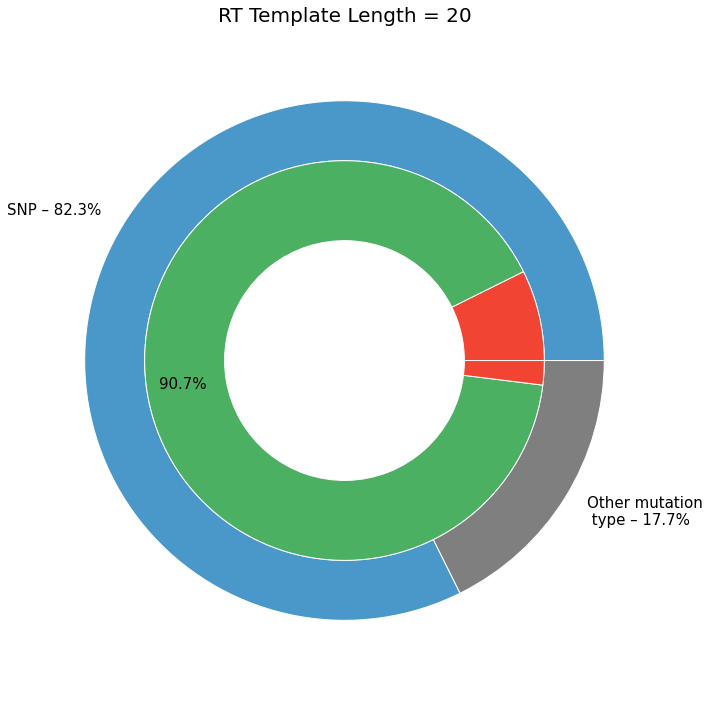

In [42]:
# Make data: I have 3 groups and 7 subgroups
group_names=['SNP – 82.3%', 'Other mutation \n type – 17.7%'] #
#group_names=['', ''] #
snp_unrecorded=0

mut_types= impact_data['Variant_Type'].value_counts()

group_size = [mut_types[0], sum(mut_types[0:])-mut_types[0]]

#subgroup_names=['editable', 'non-editable', 'non-editable','editable']

    
rt_len = 20-1
sum1 = ONP1[rt_len]+DNP1[rt_len]+INS1[rt_len]+ DEL1[rt_len] + TNP1[rt_len]

subgroup_size = [(mut_types[0]-SNP1[rt_len]), SNP1[rt_len]+sum1, (sum(mut_types[1:])-sum1)]

perc= np.round(100*np.asarray(subgroup_size)/sum(subgroup_size),1)
subgroup_names=['', str(perc[1])+'%','']
#subgroup_names=['', '','']
    
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), 'tab:gray', c(0.6)], textprops={'fontsize': 15})
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[b(0.6), c(0.6),b(0.6),c(0.6), b(0.6)], textprops={'fontsize': 15})
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

ax.set_title('RT Template Length = ' + str(rt_len+1), fontsize=20)
# show it
plt.tight_layout()
plt.show()

fig.savefig(str(rt_len+1) + '_NGG.png', dpi=250)

